In [20]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from torchcrf import CRF
from utils import get_sequences, GetLabels, My_Pad_Input, GetImgAndTextEmbs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

torch.cuda.is_available()

True

In [3]:
OUT_DIM=12
INPUT_DIM=128
BS= 8

In [4]:
dls = torch.load("./data/dls_sequence_from_embs.pth")

In [5]:
test_dl = torch.load("./data/test_dl_sequence_from_embs.pth")

In [6]:
dls.bs = dls.train.bs = dls.valid.bs = test_dl.bs = 8

In [16]:
class LSTMModel(Module):
    def __init__(self, input_dim, out_dim, hidden_dim=128):
        self.lstm = torch.nn.LSTM(input_size=hidden_dim*4, hidden_size=hidden_dim,
                                  batch_first=True, bidirectional=True).cuda()
        self.bn1 = nn.BatchNorm1d(input_dim, momentum=0.01).cuda()
        self.bn2 = nn.BatchNorm1d(hidden_dim*2, momentum=0.01).cuda()
        self.drop1 = nn.Dropout().cuda()
        self.drop2 = nn.Dropout().cuda()
        self.lin1 = nn.Linear(input_dim, hidden_dim*4).cuda()
        self.lin2 = nn.Linear(hidden_dim*2, out_dim).cuda()
        self.relu = nn.ReLU().cuda()
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.bn1(x)
        x = self.drop1(x)
        x = x.permute(0, 2, 1)
        x = self.lin1(x)
        x = self.relu(x)
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out_norm = self.bn2(out)
        out_drop = self.drop2(out_norm)
        out_drop = out_drop.permute(0, 2, 1)
        return self.lin2(out_drop)

In [17]:
model = LSTMModel(7936, 12)

In [294]:
def loss_func(out, targ, reduction="none"):
    return CrossEntropyLossFlat(ignore_index=OUT_DIM, reduction=reduction)(out, targ.long())

In [292]:
class GetLosses(Callback):
    def __init__(self):
        self.losses = []
    def after_loss(self):
        self.losses.append(self.learn.loss)

In [293]:
learn = Learner(dls, model, loss_func=loss_func)
learn.load("best_sequence_from_embs128_moreEpochs")

In [184]:
learn.summary()

LSTMModel (Input shape: ['8 x 4242 x 7936'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['8 x 4242 x 256',   657,408    True      
________________________________________________________________
BatchNorm1d          8 x 7936 x 4242      15,872     True      
________________________________________________________________
BatchNorm1d          8 x 256 x 4242       512        True      
________________________________________________________________
Dropout              8 x 7936 x 4242      0          False     
________________________________________________________________
Dropout              8 x 256 x 4242       0          False     
________________________________________________________________
Linear               8 x 4242 x 512       4,063,744  True      
________________________________________________________________
Linear               8 x 4242 x 12        3,084      True      
_____________________________________________________

In [295]:
get_losses = GetLosses()
learn.add_cb(get_losses)

In [296]:
def evaluate(learn, dl):
    preds, targets = learn.get_preds(dl=dl)
    preds =[np.argmax(x, axis=-1) for sublist in preds for x in sublist]
    targets = [x for sublist in targets for x in sublist]
    losses = learn.get_losses.losses
    pad_idxs = [i for i,x in enumerate(targets) if x != tensor([12])]
    preds = L(preds)[pad_idxs]
    targets = L(targets)[pad_idxs]
    losses = L(list(torch.cat(losses)))[pad_idxs]
    print(classification_report(targets, preds, target_names=dl.get_labels.cat.vocab, digits=4))
    preds_clean = [x % 6 for x in preds]
    targets_clean = [x % 6 for x in targets]
    print(classification_report(targets_clean, preds_clean, target_names=[x[2:] for x in dl.get_labels.cat.vocab[:6]], digits=4))
    return preds, targets, preds_clean, targets_clean, losses

In [297]:
preds, targets, preds_clean, targets_clean, losses = evaluate(learn, test_dl)

                                    precision    recall  f1-score   support

          B-acordao_de_2_instancia     0.9613    0.8744    0.9158       199
B-agravo_em_recurso_extraordinario     0.6166    0.5587    0.5862       213
     B-despacho_de_admissibilidade     0.7965    0.6122    0.6923       147
                          B-outros     0.9326    0.8898    0.9107     25744
                   B-peticao_do_RE     0.8185    0.6506    0.7250       312
                        B-sentenca     0.8584    0.7547    0.8032       265
          I-acordao_de_2_instancia     0.6296    0.9189    0.7473        74
I-agravo_em_recurso_extraordinario     0.5512    0.6677    0.6039      1628
     I-despacho_de_admissibilidade     0.5000    0.4706    0.4848        51
                          I-outros     0.9275    0.9447    0.9360     59664
                   I-peticao_do_RE     0.7988    0.7937    0.7962      6019
                        I-sentenca     0.8822    0.8174    0.8486      1210

          

In [298]:
len(losses), len(preds), len(targets)

(95526, 95526, 95526)

In [299]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=None,
                          title=None,
                          order=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=order, normalize=normalize)
    if normalize is not None:
        cm *=100

    fig, ax = plt.subplots()
    fig.set_size_inches(10,10)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig

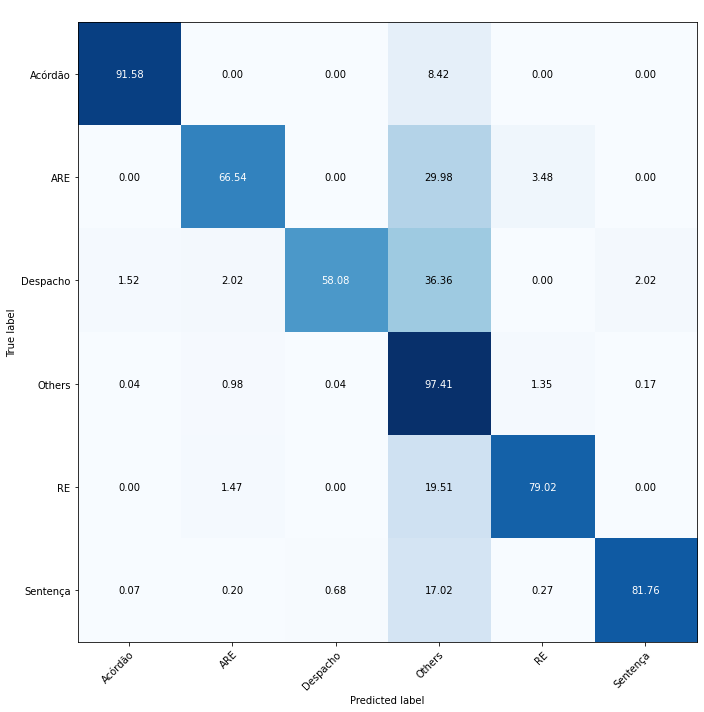

In [300]:
fig = plot_confusion_matrix(targets_clean, preds_clean, ["Acórdão", "ARE", "Despacho", "Others", "RE", "Sentença"],
                      normalize="true", title=" ")

In [57]:
fig.savefig("media/bilstm-f_cm.pdf")

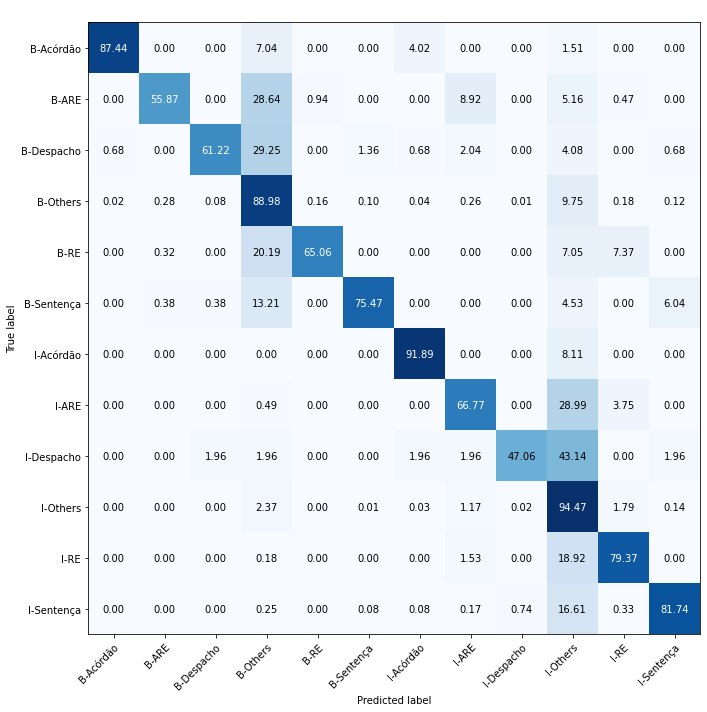

In [301]:
fig = plot_confusion_matrix(targets, preds, ["B-Acórdão","B-ARE", "B-Despacho", "B-Others", "B-RE", "B-Sentença",
                                             "I-Acórdão","I-ARE", "I-Despacho", "I-Others", "I-RE", "I-Sentença"],
                      normalize="true", title=" ")

In [69]:
fig.savefig("media/bilstm-f_cm_tags.pdf")

In [82]:
data_path = Path("/mnt/nas/backups/08-07-2020/desktopg01/lisa/Data/CSV")

In [84]:
test_df = pd.read_csv(data_path/"test_small.csv")

In [100]:
target_names = [x[2:] for x in test_dl.get_labels.cat.vocab[:6]]; target_names

['acordao_de_2_instancia',
 'agravo_em_recurso_extraordinario',
 'despacho_de_admissibilidade',
 'outros',
 'peticao_do_RE',
 'sentenca']

In [102]:
test_df["prediction"] = [target_names[x] for x in preds_clean]

In [106]:
assert (test_df["document_type"] == [target_names[x] for x in targets_clean]).all()

In [325]:
test_df["loss"] = [x.item() for x in losses]

In [347]:
grouped = test_df.groupby("prediction")

In [370]:
mistakes = []
for name, group in grouped:
    mistakes.append(group[group['document_type'] != name].nlargest(1, "loss"))

In [ ]:
mistakes = pd.concat(mistakes)

In [389]:
mistakes

,themes,process_id,file_name,document_type,pages,body,prediction,loss
22537,[766],ARE_1055151,ARE_1055151_312024095_95_19062017.pdf,outros,1,"{""sessão ordinária turma recursal paraíba certidão participaram julgamento sessão realizada data excelentíssimos juízes federais sérgio murilo wanderley queiroga rudival gama nascimento bianor arruda bezerra neto joão pessoa otavio cardoso júnior servidor turma recursal""}",acordao_de_2_instancia,43.269814
2315,[800],ARE_1002499,ARE_1002499_310470468_50_06102016.pdf,outros,4,"{""gama pessoas fora dele despertando interesse público tem aquela causa repercussão geral numa única palavra quando houver transcendência serviço saúde dever estado que fato tem dever assegurar todos cidadãos serviços gratuitos saúde como previsto constituição federal ARTIGO_196 que reproduz verbis ARTIGO_196 saúde direito todos dever estado garantido mediante políticas sociais econômicas que visem redução risco doença de outros agravos acesso universal igualitário ações serviços para sua promoção proteção recuperação ressalte que nos termos ARTIGO_199 constituição federal instituições pri...",agravo_em_recurso_extraordinario,22.593267
22548,[766],ARE_1055151,ARE_1055151_312024098_1430_19062017.pdf,outros,1,"{""decisão trata de recurso extraordinário face acórdão proferido por esta turma recursal conquanto supostamente calcado nos ARTIGO_102 iii alínea constituição federal c ARTIGO_15 LEI_10259 recurso extraordinário apreço apresenta inviável pois nas razões que embasam pedido reforma decisão recorrida não demonstra violação concreta constituição federal destarte pacífica jurisprudência supremo tribunal federal sentido não admitir re alegação ofensa indireta carta magna por interpretação aplicação mesmo inobservância normas infraconstitucionais portanto respeito repartição competência poder jud...",despacho_de_admissibilidade,82.258072
22553,[766],ARE_1055151,ARE_1055151_312024099_1420_19062017.pdf,agravo_em_recurso_extraordinario,5,"{""audiências conciliação instrução assim comprovado exercício atividade rural através início prova material corroborado pela prova testemunhal não existindo óbice concessão benefício pleiteado nos termos ARTIGO_201º constituição federal vale ainda ressaltar que recentemente stj editou súmula sendo possível reconhecer tempo serviço rural anterior documento mais antigo apresentado desde que amparado convincente prova testemunhal colhida sob contraditório recursos especiais nesse sentido início prova material extemporâneo ratificação por meio robusta prova testemunhal matéria definida sede re...",outros,87.037590
75753,[503],ARE_771863,ARE_771863_3414305_1431_12022014.pdf,outros,5,"{""advocacia geral união procuradoria geral federal procuradoria regional federal região quando segurado reúne requisitos para obtenção aposentadoria proporcional lei coloca frente uma opção sua inteira responsabilidade ele pode gozar benefício por mais tempo optar por requerê desde logo ele pode obter benefício valor mais elevado optar por permanecer trabalhando que não está aberto segurado fazer uma simbiose ambas opções aproveitando melhor cada uma preciso que segurado faça seus cálculos avalie sua expectativa vida sua necessidade imediata benefício etc assim tome sua decisão muitas veze...",peticao_do_RE,11.066406
22512,[766],ARE_1055151,ARE_1055151_312024085_26_19062017.pdf,outros,1,"{""poder judiciário justiça federal primeira instância seção judiciária paraíba juizado especial federal vara processo termo audiência instrução julgamento hora designada dia nesta cidade campina grande foi feito pregão audiência verificando presentes autor marlene oliveira barbosa advogado autor shirlei alcione sousa melo procurador réu maria carmo dos santos targino testemunhas lindalva silva nascimento via ssds concluída instrução feito provas coletadas audiência por meio digital foram anexadas aos presentes autos passou juiz proferir sentença sentença relatório dispensado ARTIGO_38 LEI_...",sentenca,35.222004


In [395]:
base_path = "/mnt/nas/backups/08-07-2020/desktopg01/lisa/Data/small_flow/test/"
for _, r in mistakes.iterrows():
    filename = r["file_name"][:-4] + "_" + str(r["pages"]) + ".jpg"
    path = base_path + r["document_type"] + "/" + filename
    ! cp {path} ./media/{"wrongest_" + r["prediction"] + ".jpg"}

In [120]:
test_df.groupby("prediction").apply(lambda x: (x[x['prediction'] != x['document_type']]).sample(1))

,,themes,process_id,file_name,document_type,pages,body,prediction
prediction,,,,,,,,
acordao_de_2_instancia,47216,[409],ARE_665808,ARE_665808_981672_49_23052013.pdf,outros,10,"{""poder judiciário justiça federal seção judiciária rio janeiro efeitos ciclo avaliação dos ativos nos termos enunciado das turmas recursais seção judiciária estado rio janeiro tem como fundamento basilar princípio isonomia a paridade entre ativos inativos torna ponto curial perquirir bases legais que deu ato aposentadoria de concessão pensão tal ocorreu após edição emenda constitucional caso presente extrai que parte autora teve seu benefício inatividade concedido dentro dos períodos requisitos acima descritos conforme inclusive restou incontroverso nos autos ante ausência impugnação espe...",acordao_de_2_instancia
agravo_em_recurso_extraordinario,2907,[800],ARE_1005033,ARE_1005033_310560254_1431_18102016.pdf,outros,3,"{""retomando a contagem prazo recursal para interposição presente recurso extraordinário até data final diante exposto tendo sido efetivamente demonstrada tempestividade presente peça processual requer desde bem como final seu acolhimento forma que exs possam apreciar razões fato de direito nela aduzidas breve resumo lide recorrido declarou que solicitou ativação fornecimento energia elétrica seu imóvel ocorre que não foi atendido por esta concessionária que supostamente vem sofrendo com alguns transtornos pela falta energia elétrica sede contestação concessionária ora recorrente esclareceu...",agravo_em_recurso_extraordinario
despacho_de_admissibilidade,20863,[810],ARE_1049848,ARE_1049848_311868884_1060_25052017.pdf,outros,2,"{""r intime belo horizonte de setembro guilherme martins damini juiz leigo embargos declaração processo promovente paulo gomes promovido estado minas gerais vistos etc nos termos ARTIGO_40 LEI_9099 homologo projeto embargos declaração para que produza seus jurídicos legais fundamentos belo horizonte de outubro karina veloso gangana tanure juiz íza direito documento assinado eletronicamente""}",despacho_de_admissibilidade
outros,35439,"[555, 852]",ARE_1076540,ARE_1076540_312770497_12_20092017.pdf,peticao_do_RE,3,"{""do novel ARTIGO_543 define que vem ser repercussão geral nos seguintes termos fls para efeito repercussão geral será considerada existência não questões relevantes ponto vista econômico político social jurídico que ultrapassem interesses subjetivos causa inicialmente registra que questão direito deste recurso foi examinada seu aspecto infraconstitucional pelo superior tribunal justiça stj procedimento recurso especial repetitivo representativo controvérsia conforme documento consulta autenticidade documento através site SITE informação extraída inf stj verbis direito previdenciário ARTIG...",outros
peticao_do_RE,55,[409],AI_859014,AI_859014_2811607_26_16052013.pdf,outros,7,"{""advocacia geral união procuradoria união paraíba mediante tramitação própria ARTIGO_64 cf poder legislativo não sendo poder judiciário competente para fazer vezes legislador sob pena ofensa toda disciplina processo legislativo previsto constituição nunca demais lembrar com devido acatamento que princípio tripartição poderes estampado ARTIGO_2º carta magna como verdadeira cláusula pétrea confere autonomia legitimidade para seus destinatários estrita acepção suas atribuições justificando assim sua eqüidistância força específicos modo que cada destes não tenha condições interferir nas atrib...",peticao_do_RE
sentenca,78992,[313],ARE_802076,ARE_802076_4169754_1324_17072015.pdf,outros,4,"{""custas honorários advocatícios dispensados nos termos ARTIGO_55 LEI_9099 intimações forma LEI_0259 recife de novembro kylce anne pereira collier mendonça juíza federal substituta vara""}",sentenca
